In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load data
data_path = 'C:\\Users\\1221\\Desktop\\Acadamy AIM 2\\Time-series-data-modeling-\\data\\processed\\processed_brent_oil_prices.csv'
data = pd.read_csv(data_path, parse_dates=['date'])
data.set_index('date', inplace=True)

In [3]:
# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Price'] = scaler.fit_transform(data[['Price']])

In [4]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 60  # 60 days of data to predict the next day
X, y = create_sequences(data['Price'].values, seq_length)

# Reshape X for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [5]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100


c:\Users\1221\Desktop\Acadamy AIM 2\Time-series-data-modeling-\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0137 - val_loss: 7.4730e-04
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0013 - val_loss: 7.8907e-04
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0011 - val_loss: 6.1706e-04
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 7.8204e-04 - val_loss: 5.4185e-04
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 7.3437e-04 - val_loss: 6.3568e-04
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 7.1511e-04 - val_loss: 5.5362e-04
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 7.2613e-04 - val_loss: 4.8686e-04
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 7.7831e-04 - val_loss: 5.8333e-04
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 6.5014e-04 - val_loss: 4.2387e-04
Epoch 10/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 6.6392e-04 - val_loss: 4.2621e-04
Epoch 11/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss:

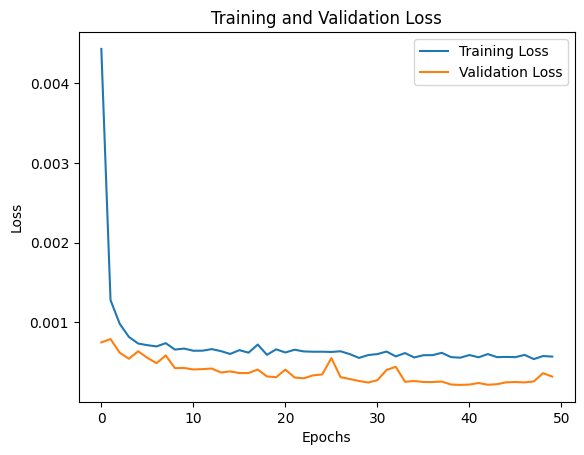

In [11]:
import matplotlib.pyplot as plt

# Assuming history is the output from model.fit()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training and validation loss curves suggest that the model is not overfitted. Here’s why:

Convergence of Training and Validation Loss: The validation loss follows the training loss closely without a significant gap. If the model were overfitting, you would expect the training loss to decrease much faster and lower than the validation loss, with the validation loss starting to increase at some point (often after a few epochs) due to overfitting.

Consistent Validation Loss: The validation loss does not show signs of increasing or fluctuating erratically at higher epochs, which is another typical indicator of overfitting.

Smooth Learning Curves: Both curves decrease smoothly and stabilize, indicating that the model is learning and generalizing well on the validation set.

In [12]:
# Import necessary libraries for evaluation
from sklearn.metrics import mean_squared_error

# Evaluate the model
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE and RMSE
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Mean Squared Error (MSE): 3.885790549173909
Root Mean Squared Error (RMSE): 1.9712408653368338


### Interpretation:
MSE (3.89): The Mean Squared Error quantifies the average squared difference between predicted and actual prices. A lower MSE indicates better performance, as it reflects smaller deviations. Since the MSE is calculated in squared units, it's often harder to interpret directly in the context of the original data.

RMSE (1.97): The Root Mean Squared Error is more interpretable, as it is in the same unit as the price. An RMSE of 1.97 indicates that, on average, the model’s predictions are off by about $1.97 from the actual price. This is a relatively small error if the overall range of oil prices in the dataset is high.

In [8]:
actual_prices

array([[46.96],
       [47.19],
       [46.09],
       ...,
       [94.25],
       [96.37],
       [93.59]])

In [9]:
predicted_prices

array([[48.156544],
       [47.697147],
       [47.376823],
       ...,
       [95.27931 ],
       [93.977455],
       [94.66729 ]], dtype=float32)

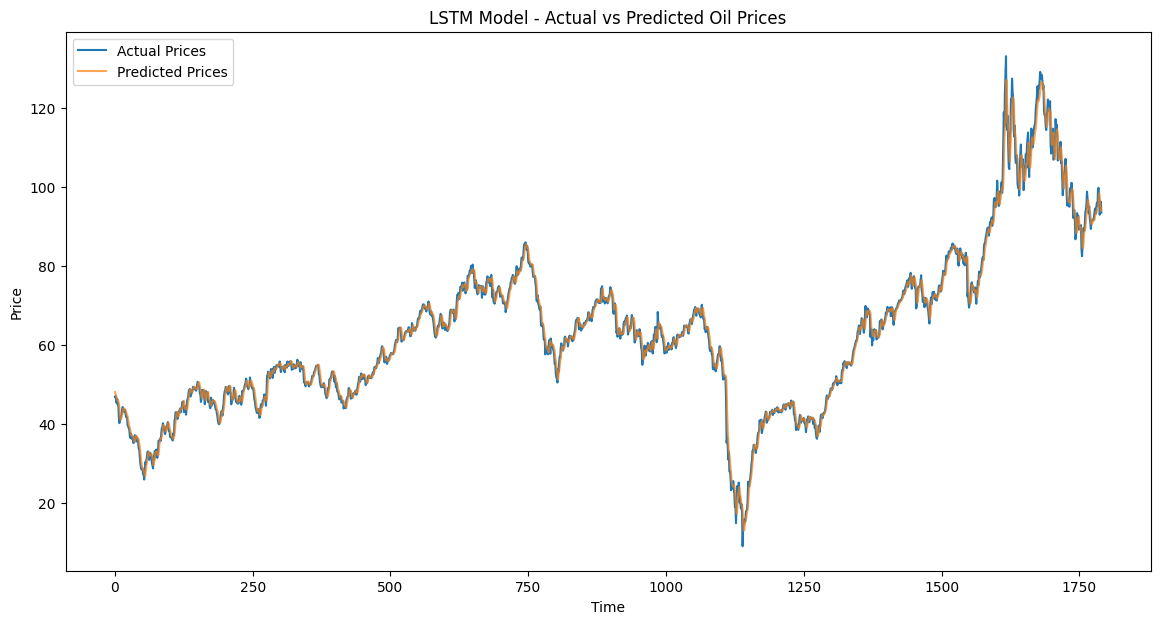

In [7]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label="Actual Prices")
plt.plot(predicted_prices, label="Predicted Prices", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("LSTM Model - Actual vs Predicted Oil Prices")
plt.legend()
plt.show()

This plot shows the actual and predicted oil prices from an LSTM model, and it appears that the model is performing well. Here are some observations:

Close Alignment: The predicted prices (orange line) closely follow the actual prices (blue line) throughout the entire time series. This suggests that the model has learned the patterns in the data effectively and is able to track the trend and volatility of the oil prices.

Trend Capture: The model captures both the upward and downward trends accurately, including sudden spikes and drops. This is a good indication that the LSTM model is capable of handling the time dependencies present in the data.

Minimal Lag: There doesn't appear to be a noticeable lag in the predictions compared to the actual prices, which is often a challenge with time series forecasting models, especially LSTMs. This suggests that the model is handling sequential dependencies effectively.

Potential for Overfitting: Given the close fit, it's worth checking the model's performance on a test set (or out-of-sample data) to ensure it generalizes well. A perfect fit on the training data may sometimes indicate overfitting, although this plot alone doesn’t confirm that.

Overall, the LSTM model seems to be accurately predicting oil prices in this timeframe, suggesting it has learned the underlying trends and seasonality present in the data.